# Complexity in fitting Linear Mixed Models

Linear mixed-effects models are increasingly used for the analysis of data from experiments in fields like psychology where several subjects are each exposed to each of several different items.
In addition to a response, which here will be assumed to be on a continuous scale, such as a _response time_, a number of experimental conditions are systematically varied during the experiment.
In the language of statistical experimental design the latter variables are called _experimental factors_ whereas factors like `Subject` and `Item` are _blocking factors_.
That is, these are known sources of variation that usually are not of interest by themselves but still should be accounted for when looking for systematic variation in the response.

## An example data set

The data from experiment 2 in [_Kronmueller and Barr (2007)_](https://www.sciencedirect.com/science/article/pii/S0749596X06000581) consist of the truncated response times, `RTtrunc`, (ms.) for target selection by 56 subjects, `subj`, (undergraduate students) on 32 `item`s (a block of displays) under combinations of 3 two-level experimental factors; Speaker, `S` (old/new), Precedent, `P`, (break/maintain), and Cognitive Load, `C` (yes/no).

These data are available as the `"kb07"` dataframe in the [_RePsychLing_ package](https://github.com/dmbates/RePsychLing/) for [__R__](http://www.R-project.org).

A copy is also available as a saved R data set, "`kb07.rds`", in this directory.
This file can be loaded into a [__Julia__](https://julialang.org) session using the [_RData_ package](https://github.com/JuliaData/RData.jl).

In [1]:
using BenchmarkTools, DataFrames, Distributions, FreqTables
using MixedModels, RData, Statistics, StatsBase, StatsModels
using Gadfly

┌ Info: Recompiling stale cache file /home/bates/.julia/compiled/v1.1/MixedModels/tBiYK.ji for MixedModels [ff71e718-51f3-5ec2-a782-8ffcbfa3c316]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/bates/.julia/compiled/v1.1/Gadfly/DvECm.ji for Gadfly [c91e804a-d5a3-530f-b6f0-dfbca275c004]
└ @ Base loading.jl:1184
┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /home/bates/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228


In [2]:
kb07 = load("kb07.rds")

,subj,item,RTtrunc,S,P,C
,Categorical…,Categorical…,Float64,Categorical…,Categorical…,Categorical…
1,30,1,2267.0,old,break,yes
2,30,2,3856.0,new,maintain,no
3,30,3,1567.0,new,break,no
4,30,4,1732.0,old,maintain,no
5,30,5,2660.0,old,break,no
6,30,6,2763.0,new,maintain,yes
7,30,7,3528.0,new,break,yes
8,30,8,1741.0,old,maintain,yes
9,30,9,3692.0,old,break,yes


In [3]:
describe(kb07)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Nothing,DataType
1,subj,,30,,103,56,,CategoricalString{UInt8}
2,item,,1,,32,32,,CategoricalString{UInt8}
3,RTtrunc,2180.49,336.0,1936.5,5143.65,,,Float64
4,S,,old,,new,2,,CategoricalString{UInt8}
5,P,,break,,maintain,2,,CategoricalString{UInt8}
6,C,,yes,,no,2,,CategoricalString{UInt8}


In [4]:
subjitemtbl = freqtable(kb07, :subj, :item)

56×32 Named Array{Int64,2}
subj ╲ item │  1   2   3   4   5   6   7   8  …  25  26  27  28  29  30  31  32
────────────┼──────────────────────────────────────────────────────────────────
30          │  1   1   1   1   1   1   1   1  …   1   1   1   1   1   1   1   1
31          │  1   1   1   1   1   1   1   1      1   1   1   1   1   1   1   1
34          │  1   1   1   1   1   1   1   1      1   1   1   1   1   1   1   1
35          │  1   1   1   1   1   1   1   1      1   1   1   1   1   1   1   1
36          │  1   1   1   1   1   1   1   1      1   1   1   1   1   1   1   1
37          │  1   1   1   1   1   1   1   1      1   1   1   1   1   1   1   1
38          │  1   1   1   1   1   1   1   1      1   1   1   1   1   1   1   1
39          │  1   1   1   1   1   1   1   1      1   1   1   1   1   1   1   1
41          │  1   1   1   1   1   1   1   1      1   1   1   1   1   1   1   1
42          │  1   1   1   1   1   1   1   1      1   1   1   1   1   1   1   1
43          │

In [5]:
countmap(vec(subjitemtbl))

Dict{Int64,Int64} with 2 entries:
  0 => 2
  1 => 1790

All of the experimental factors vary within subject and within item, as can be verified by examining the frequency tables for the experimental and grouping factors.  For example

In [6]:
freqtable(kb07, :S, :subj)

2×56 Named Array{Int64,2}
S ╲ subj │  30   31   34   35   36   37  …   97   98  100  101  102  103
─────────┼──────────────────────────────────────────────────────────────
old      │  16   16   16   16   16   16  …   16   16   16   16   16   16
new      │  16   16   16   16   16   16  …   16   16   16   16   16   16

Some of the characteristics of these data, as described in [_Kronmueller and Barr (2007)_](https://www.sciencedirect.com/science/article/pii/S0749596X06000581), can be reproduced here.  For example

In [7]:
(mean = mean(kb07.RTtrunc), std = std(kb07.RTtrunc))

(mean = 2180.493994413408, std = 934.1982213470507)

However, I have been unable to reproduce the mean response and the standard deviation for combinations of the experimental factors, as shown in Table 3 of that paper.
The results from this version of the data are

In [10]:
cellmeans = by(kb07, [:S, :P, :C], meanRT = :RTtrunc => mean, sdRT = :RTtrunc => std, n = :RTtrunc => length)

,S,P,C,meanRT,sdRT,n
,Categorical…,Categorical…,Categorical…,Float64,Float64,Int64
1,old,break,yes,2504.12,1008.82,224
2,old,break,no,2344.56,970.91,223
3,old,maintain,yes,1843.28,609.672,224
4,old,maintain,no,1760.53,586.735,224
5,new,break,yes,2672.35,1115.27,224
6,new,break,no,2534.95,1055.43,224
7,new,maintain,yes,2018.71,724.828,224
8,new,maintain,no,1764.33,675.26,223


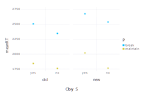

In [11]:
plot(cellmeans, x=:C, y=:meanRT, color=:P, xgroup=:S, Geom.subplot_grid(Geom.point))

According to Table 3 of that paper the mean in the first row should be 2837 and the standard deviation should be 1751.

## Formulating a simple model

A simple model with main-effects for each of the experimental factors and with random effects for subject and for item is described by the formula `RTtrunc ~ 1 + S + P + C + (1|subj) + (1|item)`.
In the _MixedModels_ package, which uses the formula specifications from the [_StatsModels_ package](https://github.com/JuliaStats/StatsModels.jl), a formula must be wrapped in a call to the `@formula` macro.
The model is created as an instance of a `LinearMixedModel` type then fit with a call to the `fit!` generic.

(By convention, the names in Julia of _mutating functions_, which modify the value of one or more of their arguments, end in `!` as a warning to the user that arguments, usually just the first argument, can be overwritten with new values.)

In [9]:
m1 = fit!(LinearMixedModel(@formula(RTtrunc ~ 1 + S + P + C + (1|subj) + (1|item)), kb07))

Linear mixed model fit by maximum likelihood
 RTtrunc ~ 1 + S + P + C + (1 | subj) + (1 | item)
     logLik        -2 logLik          AIC             BIC       
 -1.44157021×10⁴  2.88314042×10⁴  2.88454042×10⁴   2.8883834×10⁴

Variance components:
            Variance Std.Dev. 
 subj      101978.30 319.3404
 item      131612.90 362.7849
 Residual  518767.52 720.2552
 Number of obs: 1790; levels of grouping factors: 56, 32

  Fixed-effects parameters:
             Estimate Std.Error  z value P(>|z|)
(Intercept)   2526.09   84.2215  29.9934  <1e-99
S: new        134.394   34.0488  3.94709   <1e-4
P: maintain  -667.349   34.0488 -19.5998  <1e-84
C: no        -157.798   34.0487 -4.63447   <1e-5


The first fit of such a model can take several seconds because the Just-In-Time (JIT) compiler must analyze and compile a considerable amount of code.  (All of the code in the _MixedModels_ package is Julia code.)
Subsequent fits of this or similar models are much faster.

When timing fits that take a few seconds or less the `@btime` macro will be used, as it performs the evaluation of the expression several times and takes the minimum of these evaluation times.  
This is to eliminate the noise introduced by garbage collection and compilation.

Furthermore, in what follows the formulas and models will be declared `const`, which in Julia means that the type of the value cannot be changed, although the values in, say, a vector can be.

Also the expression is written using `$` before an argument name.  This is an interpolation in a macro call.  The effect is to time only the expression evaluation and not the name lookup for the arguments.

In [10]:
const f1 = @formula(RTtrunc ~ 1 + S + P + C + (1|subj) + (1|item));
@btime fit!(LinearMixedModel($f1, $kb07));

  1.976 ms (2722 allocations: 836.50 KiB)


The coding for the experimental factors in the model matrix for this model is the default or "dummy" coding, where the first level is the reference level and the estimated coefficients represent differences of the response at the indicated level relative to the first.

In this case the model matrix for the fixed effects is

In [11]:
m1.X

1790×4 Array{Float64,2}:
 1.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0
 1.0  1.0  0.0  1.0
 1.0  0.0  1.0  1.0
 1.0  0.0  0.0  1.0
 1.0  1.0  1.0  0.0
 1.0  1.0  0.0  0.0
 1.0  0.0  1.0  0.0
 1.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0
 1.0  1.0  0.0  1.0
 1.0  0.0  1.0  1.0
 1.0  0.0  0.0  1.0
 ⋮                 
 1.0  0.0  1.0  1.0
 1.0  0.0  0.0  1.0
 1.0  1.0  1.0  0.0
 1.0  1.0  0.0  0.0
 1.0  0.0  1.0  0.0
 1.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0
 1.0  1.0  0.0  1.0
 1.0  0.0  1.0  1.0
 1.0  0.0  0.0  1.0
 1.0  1.0  1.0  0.0
 1.0  1.0  0.0  0.0

In two-level factorial experiments like this it is an advantage to use a $\pm1$ coding, which can be derived from `EffectsCoding` or `HelmertCoding` (these codings are the same for a two-level factor).

In [12]:
const contrasts = Dict(:S=>HelmertCoding(), :P=>HelmertCoding(), :C=>HelmertCoding());

In [13]:
m1 = @btime fit!(LinearMixedModel($f1, $kb07, $contrasts))

  2.072 ms (2940 allocations: 844.30 KiB)


Linear mixed model fit by maximum likelihood
 RTtrunc ~ 1 + S + P + C + (1 | subj) + (1 | item)
     logLik        -2 logLik          AIC             BIC       
 -1.44157021×10⁴  2.88314042×10⁴  2.88454042×10⁴   2.8883834×10⁴

Variance components:
            Variance Std.Dev. 
 subj      101978.30 319.3404
 item      131612.90 362.7849
 Residual  518767.52 720.2552
 Number of obs: 1790; levels of grouping factors: 56, 32

  Fixed-effects parameters:
             Estimate Std.Error  z value P(>|z|)
(Intercept)   2180.72   78.8909  27.6422  <1e-99
S: new        67.1968   17.0244  3.94709   <1e-4
P: maintain  -333.674   17.0244 -19.5998  <1e-84
C: no        -78.8989   17.0244 -4.63447   <1e-5


The estimate of the `(Intercept)` coefficient is now approximately the sample mean. (It may be slightly different from the sample mean due to the   
slight imbalance in the design because of two unusually long response times being dropped.)

The coefficients for the experimental factors are half the previously estimated effects, because of the $\pm1$ coding,
Their standard errors are also half those from the previous fit.
The estimates of the variance components, the log-likelihood and other goodness of fit criteria, and the z statistics and p-values for the effects remain the same.

The model matrix for the fixed effects is now

In [14]:
m1.X

1790×4 Array{Float64,2}:
 1.0  -1.0  -1.0  -1.0
 1.0   1.0   1.0   1.0
 1.0   1.0  -1.0   1.0
 1.0  -1.0   1.0   1.0
 1.0  -1.0  -1.0   1.0
 1.0   1.0   1.0  -1.0
 1.0   1.0  -1.0  -1.0
 1.0  -1.0   1.0  -1.0
 1.0  -1.0  -1.0  -1.0
 1.0   1.0   1.0   1.0
 1.0   1.0  -1.0   1.0
 1.0  -1.0   1.0   1.0
 1.0  -1.0  -1.0   1.0
 ⋮                    
 1.0  -1.0   1.0   1.0
 1.0  -1.0  -1.0   1.0
 1.0   1.0   1.0  -1.0
 1.0   1.0  -1.0  -1.0
 1.0  -1.0   1.0  -1.0
 1.0  -1.0  -1.0  -1.0
 1.0   1.0   1.0   1.0
 1.0   1.0  -1.0   1.0
 1.0  -1.0   1.0   1.0
 1.0  -1.0  -1.0   1.0
 1.0   1.0   1.0  -1.0
 1.0   1.0  -1.0  -1.0

### Model construction versus model optimization

The `m1` object is created in the call to the constructor function, `LinearMixedModel`, then the parameters are optimized or fit in the call to `fit!`.
Usually the process of fitting a model will take longer than creating the numerical representation but, for simple models like this, the creation time can be a significant portion of the overall running time.

In [15]:
@btime LinearMixedModel($f1, $kb07, $contrasts);

  930.124 μs (1643 allocations: 810.83 KiB)


In [16]:
@btime fit!($m1);

  1.025 ms (1296 allocations: 33.38 KiB)


### Factors affecting the time to optimize the parameters

The optimization process is summarized in the `optsum` property of the model.

In [17]:
m1.optsum

Initial parameter vector: [1.0, 1.0]
Initial objective value:  28889.20544069451

Optimizer (from NLopt):   LN_BOBYQA
Lower bounds:             [0.0, 0.0]
ftol_rel:                 1.0e-12
ftol_abs:                 1.0e-8
xtol_rel:                 0.0
xtol_abs:                 [1.0e-10, 1.0e-10]
initial_step:             [0.75, 0.75]
maxfeval:                 -1

Function evaluations:     21
Final parameter vector:   [0.443371, 0.503689]
Final objective value:    28831.404175679785
Return code:              FTOL_REACHED


For this model there are two parameters to be optimized because the objective function, negative twice the log-likelihood, can be _profiled_ with respect to all the other parameters.
(See section 3 of [_Bates et al. 2015_](https://www.jstatsoft.org/article/view/v067i01) for details.)
Both these parameters must be non-negative (i.e. both have a lower bound of zero) and both have an initial value of one.
After 21 function evaluations an optimum is declared according to the function value tolerance, either $10^{-8}$ in absolute terms or $10^{-12}$ relative to the current value.

The optimization itself has a certain amount of setup and summary time but the majority of the time is spent in the evaluation of the objective - the profiled log-likelihood.

Each function evaluation is of the form

In [18]:
const θ1 = m1.θ;

In [19]:
@btime objective(updateL!(setθ!($m1, $θ1)));

  42.035 μs (57 allocations: 1.42 KiB)


Remember that this is a "best case" time.  During the course of the optimization some of the function evaluations could take longer due to garbage collection or other factors.

On this machine 21 function evaluations, each taking 42 microseconds or more, gives the total function evaluation time of at least 0.85 ms., which is practically all of the time to fit the model.

The majority of the time for the function evaluation for this model is in the call to `updateL!`

In [20]:
@btime updateL!($m1);

  32.017 μs (17 allocations: 320 bytes)


This is an operation that updates the lower Cholesky factor (often written as `L`) of a blocked sparse matrix.

There are 4 rows and columns of blocks.
The first row and column correspond to the random effects for subject, the second to the random effects for item, the third to the fixed-effects parameters and the fourth to the response.
Their sizes and types are

In [21]:
describeblocks(m1)

1,1: LinearAlgebra.Diagonal{Float64,Array{Float64,1}} (56, 56) LinearAlgebra.Diagonal{Float64,Array{Float64,1}}
2,1: Array{Float64,2} (32, 56) Array{Float64,2}
2,2: LinearAlgebra.Diagonal{Float64,Array{Float64,1}} (32, 32) Array{Float64,2}
3,1: Array{Float64,2} (4, 56) Array{Float64,2}
3,2: Array{Float64,2} (4, 32) Array{Float64,2}
3,3: Array{Float64,2} (4, 4) Array{Float64,2}
4,1: Array{Float64,2} (1, 56) Array{Float64,2}
4,2: Array{Float64,2} (1, 32) Array{Float64,2}
4,3: Array{Float64,2} (1, 4) Array{Float64,2}
4,4: Array{Float64,2} (1, 1) Array{Float64,2}


There are two lower-triangular blocked matrices: `A` with fixed entries determined by the model and data, and `L` which is updated for each evaluation of the objective function.
The type of the `A` block is given before the size and the type of the `L` block is after the size.
For scalar random effects, generated by a random-effects term like `(1|G)`, the (1,1) block is always diagonal for both `A` and `L`.
Its size is the number of levels of the grouping factor, `G`.

Because subject and item are crossed, the (2,1) block of `A` is dense, as is the (2,1) block of `L`.
The (2,2) block of `A` is diagonal because, like the (1,1) block, it is generated from a scalar random effects term.
However, the (2,2) block of `L` ends up being dense as a result of "fill-in" in the sparse Cholesky factorization.
All the blocks associated with the fixed-effects or the response are stored as dense matrices but their dimensions are (relatively) small.

## Increasing the complexity

In general, adding more terms to a model will increase the time required to fit the model.
However, there is a big difference between adding fixed-effects terms and adding complexity to the random effects.

Adding the two- and three-factor interactions to the fixed-effects terms increases the time required to fit the model.

In [22]:
const f2 = @formula(RTtrunc ~ 1 + S*P*C + (1|subj) + (1|item));

In [23]:
const m2 = @btime fit!(LinearMixedModel($f2, $kb07, $contrasts))

  4.233 ms (6168 allocations: 1.67 MiB)


Linear mixed model fit by maximum likelihood
 RTtrunc ~ 1 + S + P + C + S & P + S & C + P & C + S & P & C + (1 | subj) + (1 | item)
     logLik        -2 logLik          AIC             BIC       
 -1.44132195×10⁴  2.88264391×10⁴  2.88484391×10⁴  2.89088288×10⁴

Variance components:
            Variance   Std.Dev. 
 subj      101993.015 319.36345
 item      131638.811 362.82063
 Residual  517261.888 719.20921
 Number of obs: 1790; levels of grouping factors: 56, 32

  Fixed-effects parameters:
                              Estimate Std.Error   z value P(>|z|)
(Intercept)                    2180.66   78.8924    27.641  <1e-99
S: new                         67.1689   16.9997   3.95119   <1e-4
P: maintain                   -333.702   16.9997  -19.6299  <1e-85
C: no                         -78.9525   16.9997  -4.64436   <1e-5
S: new & P: maintain          -22.1173   16.9997  -1.30104  0.1932
S: new & C: no                -18.7454   16.9997  -1.10269  0.2702
P: maintain & C: no           -5

(Notice that none of the interactions are statistically significant.)

In this case, the increase in fitting time is more because the number of function evaluations to determine the optimum increases than because of increased evaluation time for the objective function.

In [24]:
m2.optsum.feval

39

In [25]:
const θ2 = m2.θ;

In [26]:
@btime objective(updateL!(setθ!($m2, $θ2)));

  46.950 μs (57 allocations: 1.42 KiB)


### Increasing complexity of the random effects

Another way in which the model can be extended is to switch to vector-valued random effects.
Sometimes this is described as having _random slopes_, so that a subject not only brings their own shift in the typical response but also their own shift in the change due to, say, `Load` versus `No Load`.
Instead of just one, scalar, change associated with each subject there is an entire vector of changes in the coefficients.

A model with a random slopes for each of the experimental factors for both subject and item is specified as

In [27]:
const f3 = @formula(RTtrunc ~ 1 + S*P*C + (1+S+P+C|subj) + (1+S+P+C|item));

In [28]:
const m3 = @btime fit!(LinearMixedModel($f3, $kb07, $contrasts))

  428.509 ms (642899 allocations: 27.64 MiB)


Linear mixed model fit by maximum likelihood
 RTtrunc ~ 1 + S + P + C + S & P + S & C + P & C + S & P & C + (1 + S + P + C | subj) + (1 + S + P + C | item)
     logLik        -2 logLik          AIC             BIC       
 -1.43221551×10⁴  2.86443102×10⁴  2.87023102×10⁴  2.88615194×10⁴

Variance components:
             Variance   Std.Dev.    Corr.
 subj       91237.7942 302.055945
             1943.2438  44.082239  0.77
             3772.6955  61.422272 -0.58  0.04
             4190.1286  64.731203 -0.35 -0.78 -0.54
 item      130618.3194 361.411565
             1728.1976  41.571596  0.43
            60908.7918 246.797066 -0.68  0.37
             1892.7740  43.506022 -0.31 -0.19  0.16
 Residual  444339.3955 666.587875
 Number of obs: 1790; levels of grouping factors: 56, 32

  Fixed-effects parameters:
                              Estimate Std.Error   z value P(>|z|)
(Intercept)                    2180.51   77.1967   28.2462  <1e-99
S: new                         67.0753   18.3566   3

There are several interesting aspects of this model fit.

First, the number of parameters optimized directly has increased substantially.
What was previously a 2-dimensional optimization has now become 20 dimensional.

In [29]:
m3.optsum

Initial parameter vector: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0]
Initial objective value:  29309.04765501624

Optimizer (from NLopt):   LN_BOBYQA
Lower bounds:             [0.0, -Inf, -Inf, -Inf, 0.0, -Inf, -Inf, 0.0, -Inf, 0.0, 0.0, -Inf, -Inf, -Inf, 0.0, -Inf, -Inf, 0.0, -Inf, 0.0]
ftol_rel:                 1.0e-12
ftol_abs:                 1.0e-8
xtol_rel:                 0.0
xtol_abs:                 [1.0e-10, 1.0e-10, 1.0e-10, 1.0e-10, 1.0e-10, 1.0e-10, 1.0e-10, 1.0e-10, 1.0e-10, 1.0e-10, 1.0e-10, 1.0e-10, 1.0e-10, 1.0e-10, 1.0e-10, 1.0e-10, 1.0e-10, 1.0e-10, 1.0e-10, 1.0e-10]
initial_step:             [0.75, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 0.75, 1.0, 0.75, 0.75, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 0.75, 1.0, 0.75]
maxfeval:                 -1

Function evaluations:     652
Final parameter vector:   [0.453137, 0.0511007, -0.0536417, -0.0340426, 0.0419768, 0.0708832, -0.0785956, 0.0242634, -0.0457586, 0.0, 0.542181, 0.0265869,

and the number of function evaluations to convergence has gone from under 40 to over 650.

The time required for each function evaluation has also increased considerably,

In [30]:
const θ3 = m3.θ;

In [31]:
@btime objective(updateL!(setθ!($m3, $θ3)));

  589.784 μs (559 allocations: 29.98 KiB)


resulting in much longer times for model fitting - about half a second for the "best case" on this machine.

Notice that the estimates of the fixed-effects coefficients and their standard errors have not changed substantially except for the standard error of `P` (_Precedent_), which is also the largest effect.

The parameters in the optimization for this model can be arranged as two lower-triangular 4 by 4 matrices.

In [32]:
m3.λ[1]

4×4 LinearAlgebra.LowerTriangular{Float64,Array{Float64,2}}:
  0.453137     ⋅           ⋅          ⋅ 
  0.0511007   0.0419768    ⋅          ⋅ 
 -0.0536417   0.0708832   0.0242634   ⋅ 
 -0.0340426  -0.0785956  -0.0457586  0.0

In [33]:
m3.λ[2]

4×4 LinearAlgebra.LowerTriangular{Float64,Array{Float64,2}}:
  0.542181     ⋅           ⋅          ⋅        
  0.0265869   0.0564136    ⋅          ⋅        
 -0.252078    0.271171    0.0         ⋅        
 -0.0199587  -0.00441279  0.0619658  0.00147087

which generate the covariance matrices for the random effects.
The cumulative proportion of the variance in the principal components of these covariance matrices, available as

In [34]:
m3.rePCA

2-element Array{Array{Float64,1},1}:
 [0.931288, 0.99812, 1.0, 1.0] 
 [0.850728, 0.991272, 1.0, 1.0]

show that 93% of the variation in the random effects for subject is in the first principal direction and 99% in the first two principal directions.
The random effects for item also have 99% of the variation in the first two principal directions.

Furthermore the estimates of the standard deviations of the "slope" random effects are much smaller than the those of the intercept random effects except for the `P` coefficient random effect for `item`, which suggests that the model could be reduced to `RTtrunc ~ 1 + S*P*C + (1|subj) + (1+P|item)` or even `RTtrunc ~ 1 + S+P+C + (1|subj) + (1+P|item)`.

In [35]:
const f4 = @formula(RTtrunc ~ 1 + S+P+C + (1|subj) + (1+P|item));

In [36]:
const m4 = @btime fit!(LinearMixedModel($f4, $kb07, $contrasts))

  15.163 ms (72755 allocations: 3.19 MiB)


Linear mixed model fit by maximum likelihood
 RTtrunc ~ 1 + S + P + C + (1 | subj) + (1 + P | item)
     logLik        -2 logLik          AIC             BIC       
 -1.43356888×10⁴  2.86713775×10⁴  2.86893775×10⁴  2.87387873×10⁴

Variance components:
            Variance  Std.Dev.   Corr.
 item      132370.10 363.82702
            63784.32 252.55558 -0.69
 subj       89087.40 298.47512
 Residual  460058.54 678.27615
 Number of obs: 1790; levels of grouping factors: 32, 56

  Fixed-effects parameters:
             Estimate Std.Error  z value P(>|z|)
(Intercept)   2180.62   77.3592  28.1883  <1e-99
S: new        67.1353   16.0323  4.18752   <1e-4
P: maintain  -333.736   47.4373 -7.03531  <1e-11
C: no         -78.992   16.0323 -4.92707   <1e-6


In [37]:
m4.optsum.feval

84

In [38]:
const θ4 = m4.θ;

In [39]:
@btime objective(updateL!(setθ!($m4, $θ4)));

  134.539 μs (289 allocations: 14.30 KiB)


These two model fits can be compared with one of the information criteria, `AIC` or `BIC`, for which "smaller is better".
They both indicate a preference for the smaller model, `m4`.

These criteria are values of the objective, negative twice the log-likelihood at convergence, plus a penalty that depends on the number of parameters being estimated.

Because model `m4` is a special case of model `m3`, a likelihood ratio test could also be used.
The alternative model, `m3`, will always produce an objective that is less than or equal to that from the null model, `m4`.
The difference in these value is similar to the change in the residual sum of squares in a linear model fit.
This objective would be called the _deviance_ if there was a way of defining a saturated model but it is not clear what this should be.
However, if there was a way to define a deviance then the difference in the deviances would be the same as the differences in these objectives, which is

In [40]:
diff(objective.([m3, m4]))

1-element Array{Float64,1}:
 27.06734432979283

This difference is compared to a $\chi^2$ distribution with degrees of freedom corresponding to the difference in the number of parameters

In [41]:
diff(dof.([m4, m3]))

1-element Array{Int64,1}:
 20

producing a p-value of

In [42]:
ccdf(Chisq(20), first(diff(objective.([m3,m4]))))

0.13337992341386884

The "maximal" model as proposed by [_Barr et al., 2013_](https://www.sciencedirect.com/science/article/pii/S0749596X12001180) would include all possible interactions of experimental and grouping factors.

In [43]:
const f5 = @formula(RTtrunc ~ 1 + S*P*C + (1+S*P*C|subj) + (1+S*P*C|item));

In [44]:
const m5 = @btime fit!(LinearMixedModel($f5, $kb07, $contrasts))

  5.536 s (2119524 allocations: 84.31 MiB)


Linear mixed model fit by maximum likelihood
 RTtrunc ~ 1 + S + P + C + S & P + S & C + P & C + S & P & C + (1 + S + P + S & P + C + S & C + P & C + S & P & C | subj) + (1 + S + P + S & P + C + S & C + P & C + S & P & C | item)
     logLik        -2 logLik          AIC             BIC       
 -1.42932007×10⁴  2.85864015×10⁴  2.87484015×10⁴  2.91930891×10⁴

Variance components:
             Variance   Std.Dev.    Corr.
 subj       90894.0712 301.486436
             5190.5584  72.045530  0.44
             5533.2105  74.385553 -0.47 -0.08
             8833.4931  93.986665 -0.20 -0.76  0.54
             7581.3253  87.070806 -0.21 -0.22 -0.40 -0.21
             1823.0927  42.697689  0.47  0.52 -0.10 -0.29  0.44
             7419.2475  86.135054  0.10  0.15  0.04 -0.05 -0.86 -0.70
             3787.6012  61.543491 -0.47 -0.40 -0.39 -0.18  0.09 -0.78  0.39
 item      129831.5831 360.321500
             1808.9438  42.531680  0.35
            62341.0219 249.681841 -0.68  0.46
             1027.

As is common in models with high-dimensional vector-valued random effects, the dominant portion of the variation is in the first few principal components

In [45]:
m5.rePCA

2-element Array{Array{Float64,1},1}:
 [0.727627, 0.848094, 0.941177, 0.999999, 1.0, 1.0, 1.0, 1.0]
 [0.794573, 0.941298, 0.973902, 0.994767, 1.0, 1.0, 1.0, 1.0]

For both the subjects and the items practically all the variation of these 8-dimensional random effects is in the first 4 principal components.

The dimension of $\theta$, the parameters in the optimization, increases considerably

In [46]:
const θ5 = m5.θ;
length(θ5)

72

Of these 72 parameters, 36 are estimated from variation between items, yet there are only 32 items.

Because the dimension of the optimization problem has gotten much larger the number of function evaluations to convergence increases correspondingly.

In [47]:
m5.optsum.feval

2016

Also, each function evaluation requires more time

In [48]:
@btime objective(updateL!(setθ!($m5, $θ5)));

  2.248 ms (561 allocations: 30.02 KiB)


almost all of which is for the call to `updateL!`.

In [49]:
@btime updateL!($m5);

  2.202 ms (519 allocations: 28.88 KiB)


To provide more granularity in the plots of execution time shown below, fit one more model without random effects for the third-order interaction of the experimental factors.

In [50]:
const f6 = @formula(RTtrunc ~ 1 + S*P*C + (1+S+P+C+S&P+S&C+P&C|subj) + (1+S+P+C+S&P+S&C+P&C|item));

In [51]:
const m6 = @btime fit!(LinearMixedModel($f6, $kb07, $contrasts))

  2.423 s (1511552 allocations: 58.95 MiB)


Linear mixed model fit by maximum likelihood
 RTtrunc ~ 1 + S + P + C + S & P + S & C + P & C + S & P & C + (1 + S + P + C + S & P + S & C + P & C | subj) + (1 + S + P + C + S & P + S & C + P & C | item)
     logLik        -2 logLik          AIC             BIC       
 -1.43089248×10⁴  2.86178497×10⁴  2.87478497×10⁴  2.91046978×10⁴

Variance components:
             Variance    Std.Dev.    Corr.
 subj       93325.37664 305.492024
             1394.20945  37.339114  1.00
             4059.60219  63.715008 -0.57 -0.57
             6930.92503  83.252177 -0.24 -0.24 -0.31
             6275.51213  79.218130 -0.23 -0.23  0.90 -0.26
             1160.74656  34.069731  0.65  0.65 -0.69  0.58 -0.35
             7286.10778  85.358701  0.18  0.18  0.09 -0.94 -0.05 -0.60
 item      131232.05397 362.259650
              219.29110  14.808481  1.00
            62814.77562 250.628761 -0.68 -0.68
             2227.18950  47.193109 -0.17 -0.17  0.07
              692.56617  26.316652 -0.62 -0.62  0.02  

In [52]:
const θ6 = m6.θ;
length(θ6)

56

In [53]:
@btime objective(updateL!(setθ!($m6, $θ6)));

  1.552 ms (561 allocations: 30.02 KiB)


In [54]:
@btime updateL!($m6);

  1.528 ms (519 allocations: 28.88 KiB)


## Summary of goodness of fit

Apply the goodness of fit measures to `m1` to `m6` creating a data frame

In [55]:
const mods = [m1, m2, m3, m4, m5, m6];
gofsumry = DataFrame(dof=dof.(mods), deviance=deviance.(mods),
    AIC = aic.(mods), AICc = aicc.(mods), BIC = bic.(mods))

,dof,deviance,AIC,AICc,BIC
,Int64,Float64,Float64,Float64,Float64
1,7,28831.4,28845.4,28845.5,28883.8
2,11,28826.4,28848.4,28848.6,28908.8
3,29,28644.3,28702.3,28703.3,28861.5
4,9,28671.4,28689.4,28689.5,28738.8
5,81,28586.4,28748.4,28756.2,29193.1
6,65,28617.8,28747.8,28752.8,29104.7


Here `dof` or degrees of freedom is the total number of parameters estimated in the model and `deviance` is simply negative twice the log-likelihood at convergence, without a correction for a saturated model.  All the information criteria are on a scale of "smaller is better" and all would select model 4 as "best".

In [56]:
gofnms = (:AIC, :AICc, :BIC)
map(nm -> argmin(gofsumry[nm]), NamedTuple{gofnms, NTuple{3, Symbol}}(gofnms))

(AIC = 4, AICc = 4, BIC = 4)

In [65]:
nfe(m) = length(coef(m));
nre1(m) = MixedModels.vsize(first(m.reterms));
nlv1(m) = MixedModels.nlevs(first(m.reterms));
nre2(m) = MixedModels.vsize(last(m.reterms));
nlv2(m) = MixedModels.nlevs(last(m.reterms));
nθ(m) = sum(MixedModels.nθ, m.reterms);
nev = map(m -> m.optsum.feval, mods);
μsev = [42.035, 46.950, 589.784, 134.539, 2248, 1552];
fit = [0.002072, 0.004233, 0.428509, 0.015163, 5.536, 2.423]
dimsumry = DataFrame(p = nfe.(mods), q1 = nre1.(mods), n1 = nlv1.(mods),
    q2 = nre2.(mods), n2 = nlv2.(mods), nθ = nθ.(mods),
    npar = dof.(mods), nev = nev, μsev = μsev, 
    fit = fit)

,p,q1,n1,q2,n2,nθ,npar,nev,μsev,fit
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64
1,4,1,56,1,32,2,7,21,42.035,0.002072
2,8,1,56,1,32,2,11,39,46.95,0.004233
3,8,4,56,4,32,20,29,652,589.784,0.428509
4,4,2,32,1,56,4,9,84,134.539,0.015163
5,8,8,56,8,32,72,81,2016,2248.0,5.536
6,8,7,56,7,32,56,65,1329,1552.0,2.423


In this table, `p` is the dimension of the fixed-effects vector, `q1` is the dimension of the random-effects for each of the `n1` levels of the first grouping factor while `q2` and `n2` are similar for the second grouping factor.
`nθ` is the dimension of the parameter vector and `npar` is the total number of parameters being estimated, and is equal to `nθ + p + 1`.

`nev` is the number of function evaluations to convergence.
Because this number will depend on the number of parameters in the model and several other factors such as the setting of the convergence criteria, only its magnitude should be considered reproducible.
`μsev` is the best-case time, in microseconds, per function evaluation and `fit` is the best-case time, in seconds, to fit the model.

## Relationships between model complexity and fitting time

As would be expected, the time required to fit a model increases with the complexity of the model.
In particular, the number of function evaluations to convergence increases with the number of parameters being optimized.

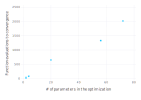

In [66]:
plot(dimsumry, x=:nθ, y=:nev, Geom.point,
    Guide.xlabel("# of parameters in the optimization"),
    Guide.ylabel("Function evaluations to convergence"))

The relationship is more-or-less linear, based on this small sample.

The time to evaluate the objective also increases with n$\theta$, the number parameters in the random-effects covariance matrices.

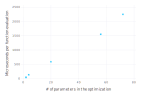

In [67]:
plot(dimsumry, x=:nθ, y=:μsev, Geom.point, 
    Guide.xlabel("# of parameters in the optimization"),
    Guide.ylabel("Microseconds per function evaluation"))

This relationship also appears linear, based on this small sample.

Finally, consider the time to fit the model versus the number of parameters in the optimization,

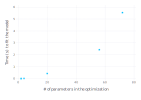

In [68]:
plot(dimsumry, x=:nθ, y=:fit, Geom.point, 
    Guide.xlabel("# of parameters in the optimization"),
    Guide.ylabel("Time (s) to fit the model"))

which, given the shape of the previous plots, would be expected to be approximately quadratic.